## Loading images and labels (training data only) and save in tfrec format

- makes it easier to get onto google colab and for reasons outlined below.

- mainly based on : https://github.com/rom1504/image_embeddings and https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c

In [34]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img


import tensorflow as tf

import pyarrow.parquet as pq
import pyarrow as pa

!pip install tqdm
import tqdm as tqdm
import time


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_path = '../data/train/' # folder contains raw image files
tfrec_path = '../data/images_train_tfrec/' #folder that tfrec files are saved to
str_list = ['_red.png', '_blue.png', '_green.png']

## Load the data

* Clone the Repository to your local machine.

* Click the link below and download the train and test data from the website into the data folder of the repository.

https://www.kaggle.com/competitions/human-protein-atlas-image-classification/data

* After downloading the data to the data folder continue with the next cell


In [35]:
# first load the training labels

train_labels = pd.read_csv("../data/train.csv")

#  delete: train_labels = train_labels[0:2000]

train_labels

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
...,...,...
31067,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
31068,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,5
31069,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,7
31070,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,25 2 21


#### Now load the images; combine the 3 colors and put them with the labels into TFRecord format

Advantages of the TFRecord format (from https://keras.io/examples/keras_recipes/creating_tfrecords/): 
- More efficient storage: the TFRecord data can take up less space than the original data; it can also be partitioned into multiple files.
- Fast I/O: the TFRecord format can be read with parallel I/O operations, which is useful for TPUs or multiple hosts.
- Self-contained files: the TFRecord data can be read from a single source—for example, the COCO2017 dataset originally stores data in two folders ("images" and "annotations").
- An important use case of the TFRecord data format is training on TPUs. First, TPUs are fast enough to benefit from optimized I/O operations. In addition, TPUs require data to be stored remotely (e.g. on Google Cloud Storage) and using the TFRecord format makes it easier to load the data without batch-downloading.

also see https://datascience.stackexchange.com/questions/16318/what-is-the-benefit-of-splitting-tfrecord-file-into-shards

In [36]:
# standard functions needed to setup the tfrec file
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, target_id):
    # could include more info in the file, if needed
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "target_id": bytes_feature(target_id)
        #"area": float_feature(example["area"]),
        #"bbox": float_feature_list(example["bbox"]),
        #"category_id": int64_feature(example["category_id"]),
        #"id": int64_feature(example["id"]),
        #"image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
    

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        # "area": tf.io.FixedLenFeature([], tf.float32),
        # "bbox": tf.io.VarLenFeature(tf.float32),
        # "category_id": tf.io.FixedLenFeature([], tf.int64),
        # "id": tf.io.FixedLenFeature([], tf.int64),
        "target_id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    #example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

def read_file(src_dir_fname):
    # reading in a png image file (one color)
    image1 = tf.io.decode_png(tf.io.read_file(src_dir_fname))#, dtype=tf.uint8)
    return image1

In [37]:
# loop through all the files, combine the 3 colors into an array and save to tfrecord
max_files = 1000

#determine the number of shards (single TFRecord files) we need:
splits = (train_labels.shape[0]//max_files) + 1 #determine how many tfr shards are needed
if train_labels.shape[0]%max_files == 0:
  splits-=1
print(f"\nUsing {splits} shard(s) for {train_labels.shape[0]} files, with up to {max_files} samples per shard")

file_count = 0

# looping through the shards and showing a progress bar (tqdm)
for i in tqdm.tqdm(range(splits)):
  current_shard_name = "{}{}_{}of{}.tfrec".format(tfrec_path,'train_images', i+1, splits)
  print(current_shard_name)
  tfrecord_writer = tf.io.TFRecordWriter(current_shard_name)

  current_shard_count = 0
  while current_shard_count < max_files: #as long as our shard is not full
     # iterate over images in directory
    index = i*max_files+current_shard_count
    if index == train_labels.shape[0]: #when we have consumed the whole data, preempt generation
        break
    file_path = base_path+'data.tfrec'
    fname = train_labels.loc[index,'Id']
    target = train_labels.loc[index,'Target']
    #for fname, target in zip(train_labels.Id, train_labels.Target):
    # try read image file
    try:
      raw_file = tf.concat([read_file(base_path+fname+end_str) for end_str in str_list], axis=2)

    except FileNotFoundError:
      print("Couldn't read file  {}".format(base_path+fname+end_str))
      continue
    # create an example with the image and label
    example = create_example(raw_file, base_path+fname+'.png', target)
    # write example
    tfrecord_writer.write(example.SerializeToString())
    current_shard_count+=1
    file_count += 1
  print('File count:', file_count)

  tfrecord_writer.close()



Using 32 shard(s) for 31072 files, with up to 1000 samples per shard


  0%|          | 0/32 [00:00<?, ?it/s]

../data/images_train_tfrec/train_images_1of32.tfrec


  3%|▎         | 1/32 [00:45<23:33, 45.59s/it]

File count: 1000
../data/images_train_tfrec/train_images_2of32.tfrec


  6%|▋         | 2/32 [01:31<22:59, 45.99s/it]

File count: 2000
../data/images_train_tfrec/train_images_3of32.tfrec


  9%|▉         | 3/32 [02:18<22:21, 46.27s/it]

File count: 3000
../data/images_train_tfrec/train_images_4of32.tfrec


 12%|█▎        | 4/32 [03:04<21:34, 46.25s/it]

File count: 4000
../data/images_train_tfrec/train_images_5of32.tfrec


 16%|█▌        | 5/32 [03:51<20:56, 46.52s/it]

File count: 5000
../data/images_train_tfrec/train_images_6of32.tfrec


 19%|█▉        | 6/32 [04:38<20:08, 46.50s/it]

File count: 6000
../data/images_train_tfrec/train_images_7of32.tfrec


 22%|██▏       | 7/32 [05:25<19:25, 46.62s/it]

File count: 7000
../data/images_train_tfrec/train_images_8of32.tfrec


 25%|██▌       | 8/32 [06:11<18:37, 46.56s/it]

File count: 8000
../data/images_train_tfrec/train_images_9of32.tfrec


 28%|██▊       | 9/32 [06:57<17:46, 46.36s/it]

File count: 9000
../data/images_train_tfrec/train_images_10of32.tfrec


 31%|███▏      | 10/32 [07:42<16:53, 46.08s/it]

File count: 10000
../data/images_train_tfrec/train_images_11of32.tfrec


 34%|███▍      | 11/32 [08:30<16:16, 46.51s/it]

File count: 11000
../data/images_train_tfrec/train_images_12of32.tfrec


 38%|███▊      | 12/32 [09:16<15:25, 46.28s/it]

File count: 12000
../data/images_train_tfrec/train_images_13of32.tfrec


 41%|████      | 13/32 [10:02<14:38, 46.25s/it]

File count: 13000
../data/images_train_tfrec/train_images_14of32.tfrec


 44%|████▍     | 14/32 [10:48<13:55, 46.40s/it]

File count: 14000
../data/images_train_tfrec/train_images_15of32.tfrec


 47%|████▋     | 15/32 [11:35<13:08, 46.39s/it]

File count: 15000
../data/images_train_tfrec/train_images_16of32.tfrec


 50%|█████     | 16/32 [12:22<12:25, 46.58s/it]

File count: 16000
../data/images_train_tfrec/train_images_17of32.tfrec


 53%|█████▎    | 17/32 [13:07<11:34, 46.28s/it]

File count: 17000
../data/images_train_tfrec/train_images_18of32.tfrec


 56%|█████▋    | 18/32 [13:54<10:47, 46.28s/it]

File count: 18000
../data/images_train_tfrec/train_images_19of32.tfrec


 59%|█████▉    | 19/32 [14:40<10:00, 46.20s/it]

File count: 19000
../data/images_train_tfrec/train_images_20of32.tfrec


 62%|██████▎   | 20/32 [15:26<09:14, 46.19s/it]

File count: 20000
../data/images_train_tfrec/train_images_21of32.tfrec


 66%|██████▌   | 21/32 [16:11<08:25, 45.99s/it]

File count: 21000
../data/images_train_tfrec/train_images_22of32.tfrec


 69%|██████▉   | 22/32 [16:57<07:38, 45.86s/it]

File count: 22000
../data/images_train_tfrec/train_images_23of32.tfrec


 72%|███████▏  | 23/32 [17:43<06:52, 45.78s/it]

File count: 23000
../data/images_train_tfrec/train_images_24of32.tfrec


 75%|███████▌  | 24/32 [18:30<06:09, 46.14s/it]

File count: 24000
../data/images_train_tfrec/train_images_25of32.tfrec


 78%|███████▊  | 25/32 [19:16<05:23, 46.16s/it]

File count: 25000
../data/images_train_tfrec/train_images_26of32.tfrec


 81%|████████▏ | 26/32 [20:02<04:36, 46.14s/it]

File count: 26000
../data/images_train_tfrec/train_images_27of32.tfrec


 84%|████████▍ | 27/32 [20:47<03:49, 45.81s/it]

File count: 27000
../data/images_train_tfrec/train_images_28of32.tfrec


 88%|████████▊ | 28/32 [21:33<03:03, 45.76s/it]

File count: 28000
../data/images_train_tfrec/train_images_29of32.tfrec


 91%|█████████ | 29/32 [22:18<02:17, 45.74s/it]

File count: 29000
../data/images_train_tfrec/train_images_30of32.tfrec


 94%|█████████▍| 30/32 [23:05<01:32, 46.00s/it]

File count: 30000
../data/images_train_tfrec/train_images_31of32.tfrec


 97%|█████████▋| 31/32 [23:51<00:46, 46.06s/it]

File count: 31000
../data/images_train_tfrec/train_images_32of32.tfrec


100%|██████████| 32/32 [23:54<00:00, 44.84s/it]

File count: 31072


## Is this one needed or is it more part of eda?

path: b'../data/train/9db105fa-bbb5-11e8-b2ba-ac1f6b6435d0.png'
target_id: b'7'
Image shape: (512, 512, 3)


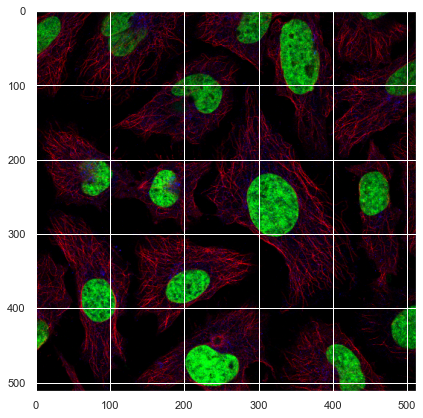

path: b'../data/train/9d1a7ec2-bbbb-11e8-b2ba-ac1f6b6435d0.png'
target_id: b'25 0'
Image shape: (512, 512, 3)


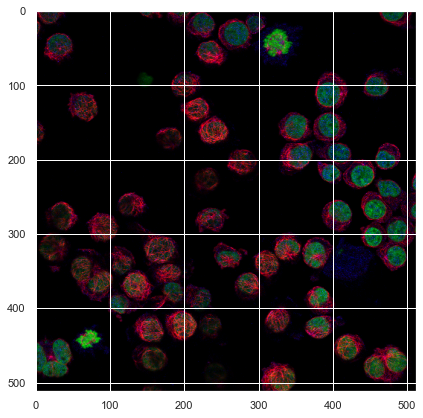

path: b'../data/train/9d26e40c-bbc3-11e8-b2bc-ac1f6b6435d0.png'
target_id: b'25 2'
Image shape: (512, 512, 3)


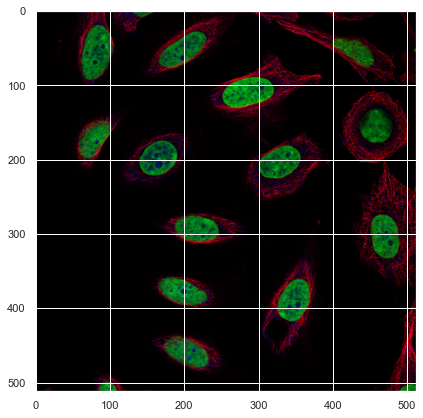

In [38]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrec_path}train_images_20of32.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.shuffle(100).take(3):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

# Simple image classification model using embeddings and Extra Tree Classifier

In this notebook we built an embedding and train a KNN model on it. 
The coding for the embedding is based on https://github.com/rom1504/image_embeddings. 

In [39]:
# Install efficientnet which includes a CNN architecture
!pip install efficientnet

#Install pyarrow which includes a python API for access to a Arrow C++ library
!pip install pyarrow

#delete previous results and create a new folder for the results of this run
!rm -rf ../data/embeddings_train
!mkdir ../data/embeddings_train

## Embeddings

Before run the rest of this notebook, load the TFRecord files, that were split into shards and saved in the notebook "Convert_train_image_labels_to_tfrec.ipynb". This is necessary because while trying to do this without shards we quickly ran out of memory.

In [40]:
#change here to your directory and make sure you have already build the folders 
base_path = '/Users/reneebrecht/neue_fische/human-protein-atlas-image-classification/data/images_train_tfrec'
embed_path = '/Users/reneebrecht/neue_fische/human-protein-atlas-image-classification/data/embeddings_train'
#select three of the four channels to fulfill RGB requirements - yellow was reported to be the least 
#informative channel 
str_list = ['_red.png', '_blue.png', '_green.png']

Following functions contain the functionalities for loading the data, for getting the embeddings, for running inference and for saving it as parquet table files.

In [41]:
def parse_tfrecord_fn(example):
    """
    parse the saved data in the TFRecord file and append 
    name and path of the file

    Parameter
    ---------
    example: dict
        Information saved in a TFRecord file
    Returns
    ---------
    example: dict 
        Information saved in a TFRecord file now with name, path and 
        target_Id for each picture
    """
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "target_id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
   
    return example

def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    """
    Save the embeddings in a special data format - Parpquet - which is good for
    handling big data

    Parameter
    ---------
    embeddings: list
        prediction of embedding function 
    dataset: TFRecordDataset
        Dataset for the embedded data
    path: str
        path to a embedded data 
    """
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    target_ids = pa.array(dataset.map(lambda image_raw, target_id, image_path: target_id).as_numpy_iterator())
    image_paths = pa.array(dataset.map(lambda image_raw, target_id, image_path: image_path).as_numpy_iterator())
    table = pa.Table.from_arrays([target_ids, image_paths, embeddings], ["target_id", "image_path", "embedding"])
    # round about way to get image name without path
    df_out = table.to_pandas()
    df_out['image_name'] = df_out['image_path'].str.decode('UTF-8').str.split('/').str[-1].str.split('.').str[0]
    df_out['image_name'] = df_out['image_name'].str.encode('UTF-8')
    # back to parquet format for saving
    table = pa.Table.from_pandas(df_out)
    pq.write_table(table, path)
    
def images_to_embeddings(model, dataset, batch_size):
    """
    Do the actual embedding. 

    Parameter
    ---------
    model: obj
        object of a class for creating an embedding (e.g. a CNN)
    dataset: TFRecordDataset
        with needed information parsed dataset
    batch_size: int
        size of dataset part run at the same time
    Returns
    ---------
    prediction: list
        prediction of the embedded dataset 
    """
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, target_id, image_path: image_raw), verbose=1)

def preprocess_image(d):
    """
    Converts pictures in a format of float32, extract the target Id and the path to the picture.
    
    Parameter
    ---------
    d: TFRecordDataset
        with needed information parsed dataset
    Returns
    ---------
    image_raw: tf.float32
        pictures in a format of float32
    target_id: str
        target ID from the from the original .csv file
    image_path: str
        path to picture
    """   
    target_id = d['target_id']
    raw = d['image']
    image_path = d['path']
    image_raw = tf.image.convert_image_dtype(raw, tf.float32)

    return image_raw, target_id, image_path

def get_dataset(file):
    """
    Get the Dataset in a workable format and parse it with all needed information

    Parameter
    ---------
    file: str
        Filename for a dataset
    Returns
    ---------
    parsed_dataset: TFRecordDataset
        with needed information parsed dataset
    """
    #create the dataset
    dataset = tf.data.TFRecordDataset(file)

    #pass every single feature through our mapping function
    #map structures that are created in functions on dataset
    parsed_dataset = dataset \
        .map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())
    return parsed_dataset

def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    """
    Get files in TFRecord format and embed each of it with all needed information parsed with it.
    Save this in a parquet in given folder.

    Parameter
    ---------
    tfrecords_folder: str
        path to folder with data which should be embedded
    output_folder: str
        path to folder where embedded data shall be saved
    model: obj
    object of a class for creating an embedding (e.g. a CNN)
    batch_size: int
        size of dataset part run at the same time
    """    
    #files = glob.glob(tfr_dir+pattern, recursive=False)
    tfrecords = [f.numpy().decode("utf-8") for f in \
                 tf.data.Dataset.list_files(tfrecords_folder + "train_images*.tfrec", shuffle=False)]
                 
    for shard_id, tfrecord in enumerate(tfrecords):
        parsed_dataset = get_dataset(tfrecord)

        embeddings = images_to_embeddings(model, parsed_dataset, batch_size)
        print("")
        print("Shard " + str(shard_id))
        current_shard_name = "{}{}_{}of{}.parquet".format(output_folder,'train_embeddings', shard_id, len(tfrecords))
        print(current_shard_name)
        save_embeddings_ds_to_parquet(embeddings, parsed_dataset,current_shard_name)
        #                                output_folder + "embedding_part-" + "{:03d}".format(shard_id) + ".parquet")

    
def run_inference(tfrecords_folder, output_folder, batch_size=100):
    """
    Choose model for embedding and run the actual embedding. 

    Parameter
    ---------
    tfrecords_folder: str
        path to folder with data which should be embedded
    output_folder: str
        path to folder where embedded data shall be saved
    batch_size:
        size of dataset part run at the same time
        Default 100
    """    
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)


In [42]:
#run the embedding by calling the running function 
if not os.path.exists(embed_path):
    # if directory doesn't exist, create and run_inference to create embeddings
    os.mkdir(embed_path)
    run_inference(base_path, embed_path, 10)


## Extra Trees Classifier model

### Prepare an Extra Trees Classifier model 

In [44]:
# load parquet files, convert to pandas and get strings as strings
emb = pq.read_table(embed_path).to_pandas()
for col in ['target_id', 'image_path', 'image_name']:
    emb[col] = emb[col].str.decode('utf-8')
emb

KeyError: 'target_id'

In [ ]:
# get the features in one dataframe
df_feats = pd.DataFrame(list(map(np.ravel, emb.embedding)))
df_feats

In [ ]:
# get the targets and one hot encode into a dataframe

# courtesy of https://www.kaggle.com/code/allunia/protein-atlas-exploration-and-baseline
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

# Dictionary is in wrong order to work with it. Turn it around.
reverse_train_labels = dict((v,k) for k,v in label_names.items())

In [ ]:
def fill_targets(row):
    """
    Modify the string with all labels in the target in a hot encoding format  

    Parameter
    ---------
    row: series
        row of the target DataFrame with all labels as a string

    Returns
    ---------
    row: series
        modified row of the target DataFrame in a hot encoding format
    """
    row.target_id = np.array(row.target_id.split(" ")).astype(np.int)
    for num in row.target_id:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

# target dataframe
targets = emb[['target_id', 'image_name']]

# add column for each protein and set to 0
for key in label_names.keys():
    targets[label_names[key]] = 0
# for each target value, set corresponding column = 1
targets = targets.apply(fill_targets, axis=1)

In [ ]:
#ID and name of Target is not needed anymore because it is encoded in the other columns
targets.drop(['target_id', 'image_name'],axis=1, inplace=True)
targets.head()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_feats, targets, random_state=1)

NameError: name 'df_feats' is not defined

### Train the model

In [ ]:
# Train model
ETC = ExtraTreesClassifier()


#use model object to create a object from a Multiclassifier 
multi_target_ETC = MultiOutputClassifier(ETC)
multi_target_ETC.fit(X_train, y_train)

NameError: name 'X_train' is not defined

### Predict data

In [ ]:
# Predict on test set
y_pred = multi_target_ETC.predict(X_test)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_pred.shape

(7768, 28)

In [ ]:

# Print confusion matrix
#sns.heatmap(multilabel_confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');
mcm = multilabel_confusion_matrix(y_test, y_pred)

tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
recall = tp / (tp + fn)
precision = tp/ (fp+tp)
specificity = tn / (tn + fp)
f1 = 2*(precision*recall)/(precision + recall)
accuracy = (tp + tn) / (tp + tn + fn + fp)

df_metrics = pd.DataFrame({'recall': recall, 'precision': precision, 'f1':f1, 'accuracy':accuracy})

# Print accuracy score 
print("Accuracy:", accuracy.round(2))
print("Precision:", precision.round(2))
print("Recall:", recall.round(2))
print("F1:", f1.round(2))
print("-----"*10)

df_metrics


Accuracy: [0.64 0.95 0.88 0.94 0.94 0.92 0.97 0.9  1.   1.   1.   0.96 0.98 0.98
 0.97 1.   0.98 0.99 0.97 0.95 0.99 0.88 0.97 0.9  0.99 0.75 0.99 1.  ]
Precision: [0.59 0.24 0.36 0.25 0.39 0.24 0.36 0.22  nan  nan  nan 0.29 0.3  0.36
 0.75  nan 0.33 0.5  0.44 0.22  nan 0.56 0.38 0.33 0.33 0.51 0.5   nan]
Recall: [0.49 0.03 0.06 0.02 0.05 0.04 0.02 0.04 0.   0.   0.   0.02 0.02 0.06
 0.1  0.   0.01 0.02 0.04 0.02 0.   0.14 0.01 0.06 0.02 0.3  0.03  nan]
F1: [0.53 0.05 0.11 0.04 0.09 0.07 0.04 0.07  nan  nan  nan 0.03 0.03 0.1
 0.17  nan 0.02 0.04 0.07 0.03  nan 0.22 0.03 0.1  0.04 0.38 0.05  nan]
--------------------------------------------------


/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_49408/2543887288.py:10: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_49408/2543887288.py:11: RuntimeWarning: invalid value encountered in divide
  precision = tp/ (fp+tp)


,recall,precision,f1,accuracy
0,0.491033,0.587495,0.534950,0.644567
1,0.026549,0.243243,0.047872,0.953913
2,0.062159,0.363057,0.106145,0.876416
3,0.024155,0.250000,0.044053,0.944130
4,0.048611,0.388889,0.086420,0.942842
5,0.039539,0.240000,0.067893,0.915165
6,0.021277,0.357143,0.040161,0.969233
7,0.038627,0.223140,0.065854,0.901390
8,0.000000,NaN,NaN,0.997812
9,0.000000,NaN,NaN,0.998069


<AxesSubplot:>

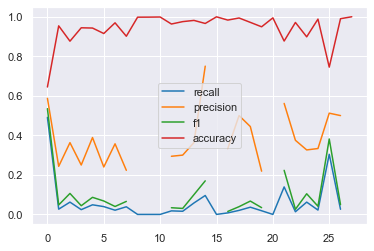

In [ ]:
df_metrics.plot()

The model only gives reasonable prediction for the first and the 25th feature. This are the features most often labeled in the pictures. <br>
To get better results for the other features we need to build model extra for that feature. The best two we can go on together in one CNN. 